In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         pass
        # print(os.path.join(dirname, filename))
# /kaggle/input/dogs-vs-cats/dogs_vs_cats
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
import matplotlib.image as mpimg

## Data Visualization

In [5]:
path = '/kaggle/input/dogs-vs-cats/train'
classes = os.listdir(path)
classes

['dogs', 'cats']

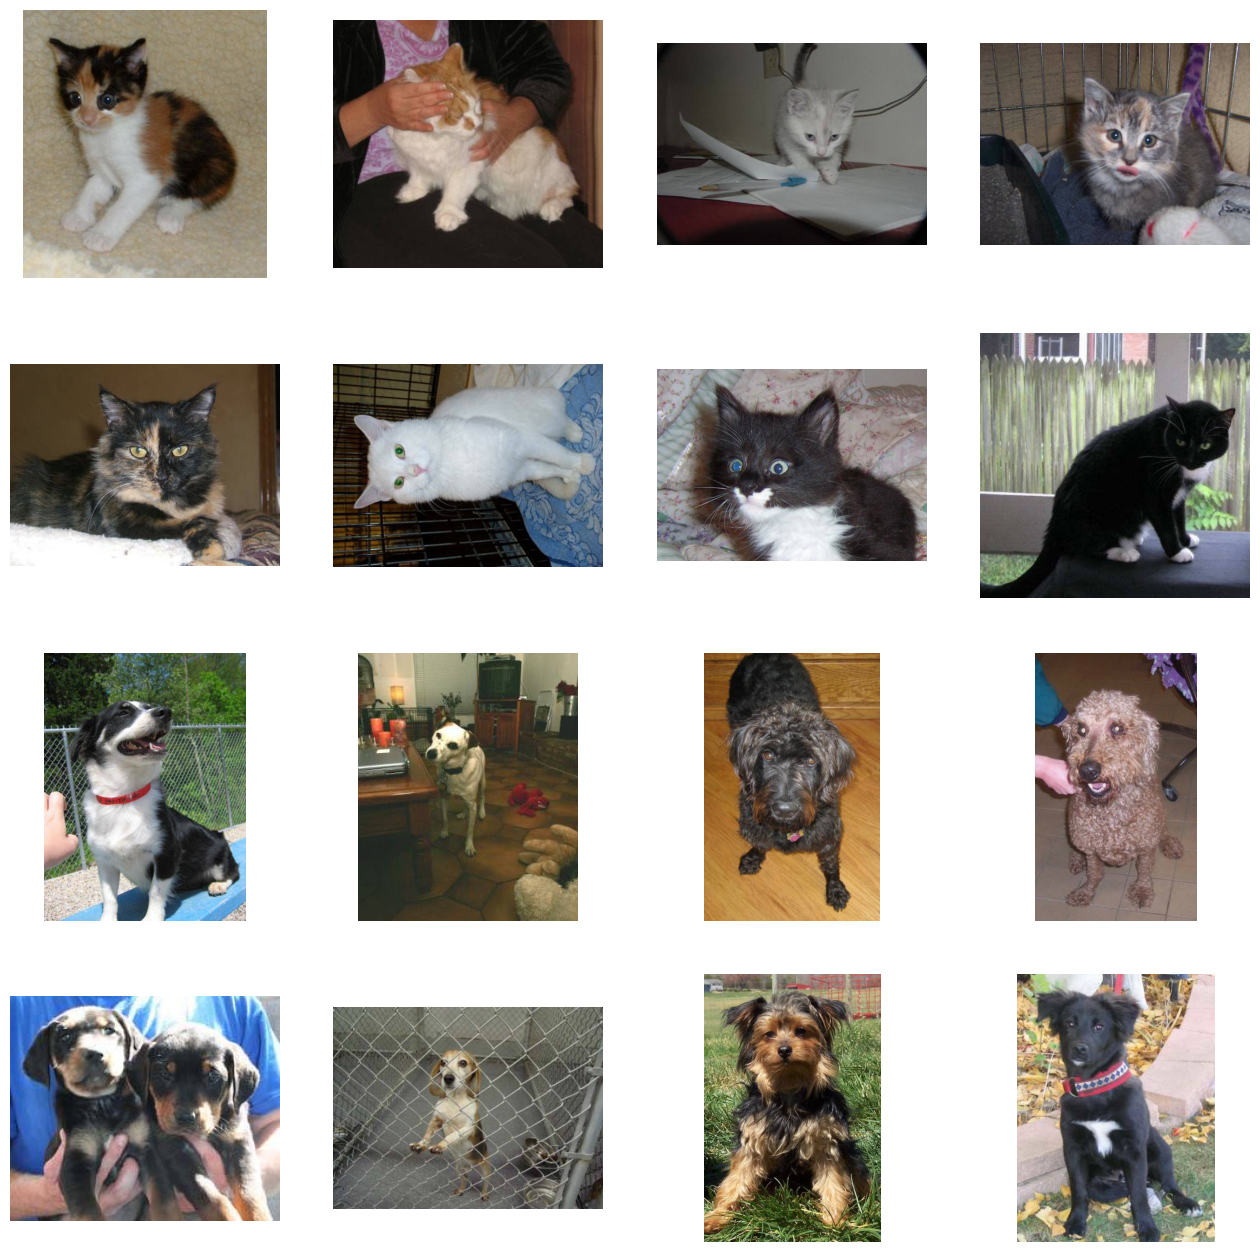

In [6]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

cat_dir = os.path.join('/kaggle/input/dogs-vs-cats/train/cats')
dog_dir = os.path.join('/kaggle/input/dogs-vs-cats/train/dogs')
cat_names = os.listdir(cat_dir)
dog_names = os.listdir(dog_dir)

pic_index = 210

cat_images = [os.path.join(cat_dir, fname)
              for fname in cat_names[pic_index-8:pic_index]]
dog_images = [os.path.join(dog_dir, fname)
              for fname in dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(cat_images + dog_images):
    sp = plt.subplot(4, 4, i+1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Data Preparation for Training

In [8]:
# Create datasets
train_datagen = image_dataset_from_directory(directory ="/kaggle/input/dogs-vs-cats/train",
                                             labels="inferred",
                                             label_mode="int",
                                                  image_size=(256,256),
                                                  seed = 1,
                                                  batch_size= 48)
test_datagen = image_dataset_from_directory(directory ="/kaggle/input/dogs-vs-cats/test",
                                            labels="inferred",
                                            label_mode="int",
                                                  image_size=(256,256),
                                                  subset='validation',
                                                  seed = 1,
                                                 validation_split=0.1,
                                                  batch_size= 48)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Using 500 files for validation.


In [9]:
def normalize(image, lable):
    image = tf.cast(image/255, tf.float32)
    return image, lable

train_datagen = train_datagen.map(normalize)
test_datagen = test_datagen.map(normalize)

## Model Architecture

In [10]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [16]:
# Open a strategy scope.
with strategy.scope():
    model = Sequential()
    
    # Step 1: Input layer
    model.add(Input(shape=(256, 256, 3)))
    
    # Step 2: Convolutional layers with max pooling
    model.add(Conv2D(32, kernel_size = (3, 3), padding = 'valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding = 'valid', strides = 2))
    
    model.add(Conv2D(64, kernel_size = (3, 3), padding = 'valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding = 'valid', strides = 2))
    
    model.add(Conv2D(128, kernel_size = (3, 3), padding = 'valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding = 'valid', strides = 2))
    
    model.add(Conv2D(128, kernel_size = (3, 3), padding = 'valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding = 'valid', strides = 2))
    
    # Step 3: Flatten layer
    model.add(Flatten())
    
    # Step 4: Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    # Step 5: Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,420,865 (51.20 MB)

 Trainable params: 13,417,857 (51.19 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [17]:
# keras.utils.plot_model(
#     model,
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_activations=True
# )

In [18]:
# model.compile(
#     loss='binary_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

## Model Training 

In [19]:
history = model.fit(train_datagen,
          epochs=10,
          validation_data=test_datagen)

Epoch 1/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 74s 147ms/step - accuracy: 0.5990 - loss: 0.7449 - val_accuracy: 0.5880 - val_loss: 0.8089
Epoch 2/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - accuracy: 0.7257 - loss: 0.5526 - val_accuracy: 0.7760 - val_loss: 0.4680
Epoch 3/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 145ms/step - accuracy: 0.7795 - loss: 0.4634 - val_accuracy: 0.8280 - val_loss: 0.3955
Epoch 4/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 61s 146ms/step - accuracy: 0.8182 - loss: 0.4075 - val_accuracy: 0.8160 - val_loss: 0.3833
Epoch 5/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - accuracy: 0.8414 - loss: 0.3685 - val_accuracy: 0.8440 - val_loss: 0.3463
Epoch 6/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - accuracy: 0.8637 - loss: 0.3175 - val_accuracy: 0.8200 - val_loss: 0.4576
Epoch 7/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - accuracy: 0.8836 - loss: 0.2805 - val_accuracy: 0.8840 - val_loss: 0.2887
Epoch 8/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 60s 144ms/step - accuracy: 0.9084 - loss: 0

## Model Evaluation

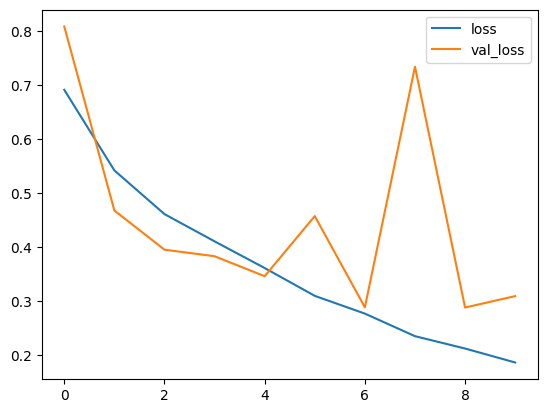

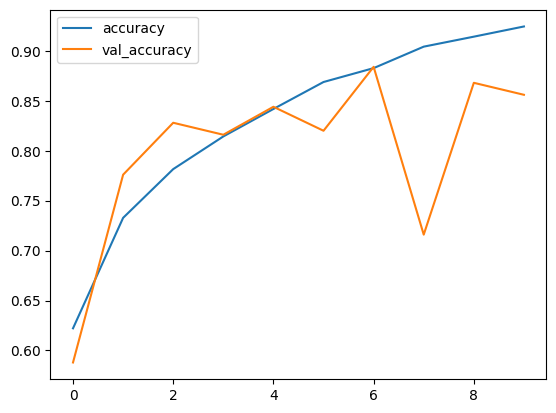

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

## Model Testing and Prediction

In [21]:
# from keras.preprocessing import image

# #Input image
# test_image = image.load_img('1.jpg',target_size=(200,200))

# #For show image
# plt.imshow(test_image)
# test_image = image.img_to_array(test_image)
# test_image = np.expand_dims(test_image,axis=0)

# # Result array
# result = model.predict(test_image)

# #Mapping result array with the main name list
# i=0
# if(result>=0.5):
#   print("Dog")
# else:
#   print("Cat")

In [ ]:
# test_image = image.load_img('test/2.jpg', target_size=(200, 200))

# # For show image
# plt.imshow(test_image)
# test_image = image.img_to_array(test_image)
# test_image = np.expand_dims(test_image, axis=0)

# # Result array
# result = model.predict(test_image)
# # Mapping result array with the main name list
# i = 0
# if(result >= 0.5):
#     print("Dog")
# else:
#     print("Cat")